###### Content under Creative Commons Attribution license CC-BY 4.0, code under MIT license (c)2014 L.A. Barba, G.F. Forsyth.  

# Relax and hold steady

Ready for more relaxing? This is the third lesson of **Module 5** of the course, exploring solutions to elliptic PDEs.
In [Lesson 1](http://nbviewer.ipython.org/github/numerical-mooc/numerical-mooc/blob/master/lessons/05_relax/05_01_2D.Laplace.Equation.ipynb) and [Lesson 2](http://nbviewer.ipython.org/github/numerical-mooc/numerical-mooc/blob/master/lessons/05_relax/05_02_2D.Poisson.Equation.ipynb) of this module we used the Jacobi method (a relaxation scheme) to iteratively find solutions to Laplace and Poisson equations.

And it worked, so why are we still talking about it?  Because the Jacobi method is slow, very slow to converge.  It might not have seemed that way in the first two notebooks because we were using small grids, but we did need more than 3,000 iterations to reach the exit criterion while solving the Poisson equation on a $41\times 41$ grid. 

You can confirm this below: using `nx,ny=` $128$ on the Laplace problem of Lesson 1, the Jacobi method requires nearly *20,000* iterations before we reach $10^{-8}$ for the L2-norm of the difference between two iterates. That's a *lot* of iterations!

Now, consider this application:  an incompressible Navier-Stokes solver has to ensure that the velocity field is divergence-free at every timestep.  One of the most common ways to ensure this is to solve a Poisson equation for the pressure field. In fact, the pressure Poisson equation is responsible for the majority of the computational expense of an incompressible Navier-Stokes solver. Imagine having to do 20,000 Jacobi iterations for *every* time step in a fluid-flow problem with many thousands or perhaps millions of grid points! 

The Jacobi method is the slowest of all relaxation schemes, so let's learn how to improve on it. In this lesson, we'll study the Gauss-Seidel method—twice as fast as Jacobi, in theory—and the successive over-relaxation (SOR) method. We also have some neat Python tricks lined up for you to get to the solution even faster. Let's go!


### Test problem

Let's use the same example problem as in [Lesson 1](./05_01_2D.Laplace.Equation.ipynb): Laplace's equation with boundary conditions

\begin{equation}
  \begin{gathered}
p=0 \text{ at } x=0\\
\frac{\partial p}{\partial x} = 0 \text{ at } x = L\\
p = 0 \text{ at }y = 0 \\
p = \sin \left(  \frac{\frac{3}{2}\pi x}{L} \right) \text{ at } y = H
  \end{gathered}
\end{equation}

We import our favorite Python libraries, and also some custom functions that we wrote in [Lesson 1](./05_01_2D.Laplace.Equation.ipynb), which we have saved in a 'helper' Python file for re-use. 

In [8]:
import numpy
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

In [9]:
from laplace_helper import p_analytical, plot_3D, L2_rel_error

We now have the analytical solution in the array `p_analytical`, and we have the functions `plot_3D` and `L2_rel_error` in our namespace.  If you can't remember how they work, just use `help()` and take advantage of the docstrings.  It's a good habit to always write docstrings in your functions, and now you see why!

In this notebook, we are going to use larger grids than before, to better illustrate the speed increases we achieve with different iterative methods. Let's create a $128\times128$ grid and initialize. 

In [10]:
nx = 128
ny = 128

L = 5
H = 5

x = numpy.linspace(0,L,nx)
y = numpy.linspace(0,H,ny)

dx = L/(nx-1)
dy = H/(ny-1)

p0 = numpy.zeros((ny, nx))

p0[-1,:] = numpy.sin(1.5*numpy.pi*x/x[-1])

We said above that the Jacobi method takes nearly 20,000 iterations before it satisfies our exit criterion of $10^{-8}$ (L2-norm difference between two consecutive iterations). You'll just have to confirm that now. Have a seat!  

In [11]:
def laplace2d(p, l2_target):
    '''Solves the Laplace equation using the Jacobi method 
    with a 5-point stencil
    
    Parameters:
    ----------
    p: 2D array of float
        Initial potential distribution
    l2_target: float
        Stopping criterion
        
    Returns:
    -------
    p: 2D array of float
        Potential distribution after relaxation
    '''
    
    l2norm = 1
    pn = numpy.empty_like(p)
    iterations = 0

    while l2norm > l2_target:
        pn = p.copy()
        p[1:-1,1:-1] = .25 * (pn[1:-1,2:] + pn[1:-1,:-2] +\
                              pn[2:,1:-1] + pn[:-2,1:-1])
        
        ##Neumann B.C. along x = L
        p[1:-1,-1] = .25 * (2*pn[1:-1,-2] + pn[2:,-1] + pn[:-2, -1])
        
        l2norm = numpy.sqrt(numpy.sum((p - pn)**2)/numpy.sum(pn**2))
        iterations += 1
     
    return p, iterations

In [12]:
l2_target = 1e-8
p, iterations = laplace2d(p0.copy(), l2_target)

print ("Jacobi method took {} iterations at tolerance {}".\
        format(iterations, l2_target))

Jacobi method took 19993 iterations at tolerance 1e-08


Would we lie to you?  19,993 iterations before we reach the exit criterion of $10^{-8}$.  Yikes!

We can also time how long the Jacobi method takes using the `%%timeit` cell-magic.  Go make some tea, because this can take a while—the `%%timeit` magic runs the function a few times and then averages their runtimes to give a more accurate result.  

- - -
##### Notes

1. When using `%%timeit`, the return values of a function (`p` and `iterations` in this case) *won't* be saved.

2. We document our timings below, but your timings can vary quite a lot, depending on your hardware. In fact, you may not even see the same trends (some recent hardware can play some fancy tricks with optimizations that you have no control over).
- - -

With those caveats, let's give it a shot:

In [13]:
%%timeit
laplace2d(p0.copy(), l2_target)

1 loop, best of 3: 4.11 s per loop


The printed result above (and others to come later) is from a mid-2007 Mac Pro, powered by two 3-GHz quad-core Intel Xeon X5364 (Clovertown). We tried also on more modern machines, and got conflicting results—like the Gauss-Seidel method being slightly slower than Jacobi, even though it required fewer iterations. Don't get too hung up on this: the hardware optimizations applied by more modern CPUs are varied and make a big difference sometimes.

Meanwhile, let's check the overall accuracy of the numerical calculation by comparing it to the analytical solution.

In [14]:
pan = p_analytical(x,y)

In [15]:
L2_rel_error(p,pan)

6.1735513352973877e-05

That's a pretty small error.  Let's assume it is good enough and focus on speeding up the process.  

## Gauss-Seidel

You will recall from [Lesson 1](./05_01_2D.Laplace_Equation.ipynb) that a single Jacobi iteration is written as:

\begin{equation}
p^{k+1}_{i,j} = \frac{1}{4} \left(p^{k}_{i,j-1} + p^k_{i,j+1} + p^{k}_{i-1,j} + p^k_{i+1,j} \right)
\end{equation}

The Gauss-Seidel method is a simple tweak to this idea: use updated values of the solution as soon as they are available, instead of waiting for the values in the whole grid to be updated. 

If you imagine that we progress through the grid points in the order shown by the arrow in Figure 1, then you can see that the updated values $p^{k+1}_{i-1,j}$ and $p^{k+1}_{i,j-1}$ can be used to calculate $p^{k+1}_{i,j}$.

<img src="./figures/solvepath.svg" width=350>

#### Figure 1. Assumed order of updates on a grid.

The iteration formula for Gauss-Seidel is thus:

\begin{equation}
p^{k+1}_{i,j} = \frac{1}{4} \left(p^{k+1}_{i,j-1} + p^k_{i,j+1} + p^{k+1}_{i-1,j} + p^k_{i+1,j} \right)
\end{equation}

There's now a problem for the Python implementation.  You can no longer use NumPy's array operations to evaluate the solution updates.  Since Gauss-Seidel requires using values immediately after they're updated, we have to abandon our beloved array operations and return to nested `for` loops. Ugh.  

We don't like it, but if it saves us a bunch of time, then we can manage. But does it? 

Here's a function to compute the Gauss-Seidel updates using a double loop.

In [16]:
def laplace2d_gauss_seidel(p, nx, ny, l2_target):
    
    iterations = 0
    iter_diff = l2_target+1 #init iter_diff to be larger than l2_target
    
    while iter_diff > l2_target:
        pn = p.copy()
        iter_diff = 0.0
        for j in range(1,ny-1):
            for i in range(1,nx-1):
                p[j,i] = .25 * (p[j,i-1] + p[j,i+1] + p[j-1,i] + p[j+1,i])
                iter_diff += (p[j,i] - pn[j,i])**2
        
        #Neumann 2nd-order BC
        for j in range(1,ny-1):
            p[j,-1] = .25 * (2*p[j,-2] + p[j+1,-1] + p[j-1, -1])
            
        iter_diff = numpy.sqrt(iter_diff/numpy.sum(pn**2))
        iterations += 1        
        
    return p, iterations

We would then run this with the following function call:

```Python
p, iterations = laplace2d_gauss_seidel(p,1e-8)
```

<br>
But **don't do it**.  We did it so that you don't have to!  

The solution of our test problem with the Gauss-Seidel method required several thousand fewer iterations than the Jacobi method, but it took nearly *10 minutes* to run on our machine.

##### What happened?

If you think back to the far off days when you first learned about array operations, you might recall that we discovered that NumPy array operations could drastically improve code performance compared with nested `for` loops.  NumPy operations are written in C and pre-compiled, so they are *much* faster than vanilla Python.  

But the Jacobi method is not algorithmically optimal, giving slow convergence.  We want to take advantage of the faster-converging iterative methods, yet unpacking the array operations into nested loops destroys performance. *What can we do?*

## Use Numba!

[Numba](http://numba.pydata.org) is an open-source optimizing compiler for Python. It works by reading Python functions that you give it, and generating a compiled version for you—also called Just-In-Time (JIT) compilation.  You can then use the function at performance levels that are close to what you can get with compiled languages (like C, C++ and fortran).

It can massively speed up performance, especially when dealing with loops.  Plus, it's pretty easy to use. Like we overheard at a conference: [*Numba is a Big Deal.*](http://twitter.com/lorenaabarba/status/625383941453656065)

##### Caveat

We encourage everyone following the course to use the [Anaconda Python](https://www.continuum.io/downloads) distribution because it's well put-together and simple to use.  If you *haven't* been using Anaconda, that's fine, but let us **strongly** suggest that you take the plunge now.  Numba is great and easy to use, but it is **not** easy to install without help.  Those of you using Anaconda can install it by running <br><br>

`conda install numba`<br><br>

If you *really* don't want to use Anaconda, you will have to [compile all of Numba's dependencies](https://pypi.python.org/pypi/numba).


- - -

### Intro to Numba

Let's dive in!  Numba is great and easy to use.  We're going to first walk you through a simple example to give you a taste of Numba's abilities.  

After installing Numba (see above), we can use it by adding a line to `import numba` and another to `import autojit` (more on this in a bit).

In [17]:
import numba
from numba import jit

You tell Numba which functions you want to accelerate by using a [Python decorator](http://www.learnpython.org/en/Decorators), a special type of command that tells the Python interpreter to modify a callable object (like a function). For example, let's write a quick function to calculate the $n^{\text{th}}$ number in the Fibonacci sequence:

In [18]:
def fib_it(n):
    a = 1
    b = 1
    for i in range(n-2):
        a, b = b, a+b
        
    return b

There are several faster ways to program the Fibonacci sequence, but that's not a concern right now (but if you're curious, [check them out](http://mathworld.wolfram.com/BinetsFibonacciNumberFormula.html)).  Let's use `%%timeit` and see how long this simple function takes to find the 500,000-th Fibonacci number.

In [19]:
%%timeit
fib_it(500000)

1 loop, best of 3: 3.52 s per loop


Now let's try Numba!  Just add the `@jit` decorator above the function name and let's see what happens!

In [20]:
@jit
def fib_it(n):
    a = 1
    b = 1
    for i in range(n-2):
        a, b = b, a+b
        
    return b

In [21]:
%%timeit
fib_it(500000)

The slowest run took 532.97 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 302 µs per loop


*Holy cow!* In our machine, that's more than 8,000 times faster!

That warning from `%%timeit` is due to the compilation overhead for Numba.  The very first time that it executes the function, it has to compile it, then it caches that code for reuse without extra compiling.  That's the 'Just-In-Time' bit.  You'll see it disappear if we run `%%timeit` again.

In [22]:
%%timeit
fib_it(500000)

1000 loops, best of 3: 300 µs per loop


We would agree if you think that this is a rather artificial example, but the speed-up is very impressive indeed. Just adding the one-word decorator!

##### Running in `nopython` mode

Numba is very clever, but it can't optimize everything.  When it can't, rather than failing to run, it will fall back to the regular Python, resulting in poor performance again.  This can be confusing and frustrating, since you might not know ahead of time which bits of code will speed up and which bits won't.  

To avoid this particular annoyance, you can tell Numba to use `nopython` mode. In this case, your code will simply fail if the "jitted" function can't be optimized. It's simply an option to give you "fast or nothing."

Use `nopython` mode by adding the following line above the function that you want to JIT-compile:

```Python
@jit(nopython=True)
```

- - -

##### Numba version check

In these examples, we are using the latest (as of publication) version of Numba: 0.22.1.  Make sure to upgrade or some of the code examples below may not run.  


- - -

In [23]:
print(numba.__version__)

0.27.0


## Back to Jacobi

We want to compare the performance of different iterative methods under the same conditions. Because the Gauss-Seidel method forces us to unpack the array operations into nested loops (which are very slow in Python), we use Numba to get the code to perform well. Thus, we need to write a new Jacobi method using for-loops and Numba (instead of NumPy), so we can make meaningful comparisons. 

Let's write a "jitted" Jacobi with loops.

In [24]:
@jit(nopython=True)
def laplace2d_jacobi(p, pn, l2_target):
    '''Solves the Laplace equation using the Jacobi method 
    with a 5-point stencil
    
    Parameters:
    ----------
    p: 2D array of float
        Initial potential distribution
    pn: 2D array of float
        Allocated array for previous potential distribution
    l2_target: float
        Stopping criterion
        
    Returns:
    -------
    p: 2D array of float
        Potential distribution after relaxation
    '''
        
    iterations = 0
    iter_diff = l2_target+1 #init iter_diff to be larger than l2_target
    denominator = 0.0
    ny, nx = p.shape
    l2_diff = numpy.zeros(20000)
    
    while iter_diff > l2_target:
        for j in range(ny):
            for i in range(nx):
                pn[j,i] = p[j,i]
                
        iter_diff = 0.0
        denominator = 0.0
        
        for j in range(1,ny-1):
            for i in range(1,nx-1):
                p[j,i] = .25 * (pn[j,i-1] + pn[j,i+1] + pn[j-1,i] + pn[j+1,i])
                
        
        #Neumann 2nd-order BC
        for j in range(1,ny-1):
            p[j,-1] = .25 * (2*pn[j,-2] + pn[j+1,-1] + pn[j-1, -1])
            
            
        for j in range(ny):
            for i in range(nx):
                iter_diff += (p[j,i] - pn[j,i])**2
                denominator += (pn[j,i]*pn[j,i])
        
        
        iter_diff /= denominator
        iter_diff = iter_diff**0.5
        l2_diff[iterations] = iter_diff
        iterations += 1    
        
    return p, iterations, l2_diff

In [25]:
p, iterations, l2_diffJ = laplace2d_jacobi(p0.copy(), p0.copy(), 1e-8)

print("Numba Jacobi method took {} iterations at tolerance {}".format(iterations, l2_target))

Numba Jacobi method took 19993 iterations at tolerance 1e-08


In [26]:
%%timeit 
laplace2d_jacobi(p0.copy(), p0.copy(), 1e-8)

1 loop, best of 3: 976 ms per loop


In our old machine, that's faster than the NumPy version of Jacobi, but on some newer machines it might not be. Don't obsess over this: there is much hardware black magic that we cannot control.

Remember that NumPy is a highly optimized library.  The fact that we can get competitive execution times with this JIT-compiled code is kind of amazing.  Plus(!) now we get to try out those techniques that aren't possible with NumPy array operations.

##### Note

We're also saving the history of the L2-norm of the difference between consecutive iterations.  We'll take a look at that once we have a few more methods to compare.
- - -


##### Another Note

Why did we use 

```Python
l2_diff = numpy.zeros(20000)
```

Where did the `20000` come from? 

We cheated a little bit.  Numba doesn't handle _mutable_ objects well in `nopython` mode, which means we can't use a *list* and append each iteration's value of the L2-norm.  So we need to define an array big enough to hold all of them and we know from the first run that Jacobi converges in fewer than 20,000 iterations.


- - -

##### Challenge task

It is possible to get a good estimate of the number of iterations needed by the Jacobi method to reduce the initial error by a factor $10^{-m}$, for given $m$. The formula depends on the largest eigenvalue of the coefficient matrix, which is known for the discrete Poisson problem on a square domain. See Parviz Moin, *"Fundamentals of Engineering Numerical Analysis"* (2nd ed., pp.141–143).

* Find the estimated number of iterations to reduce the initial error by $10^{-8}$ when using the grids listed below, in the section on grid convergence, with $11$, $21$, $41$ and $81$ grid points on each coordinate axis.

## Back to Gauss-Seidel

If you recall, the reason we got into this Numba sidetrack was to try out Gauss-Seidel and compare the performance with Jacobi.  Recall from above that the formula for Gauss-Seidel is as follows:

\begin{equation}
p^{k+1}_{i,j} = \frac{1}{4} \left(p^{k+1}_{i,j-1} + p^k_{i,j+1} + p^{k+1}_{i-1,j} + p^k_{i+1,j} \right)
\end{equation}

We only need to slightly tweak the Jacobi function to get one for Gauss-Seidel.  Instead of updating `p` in terms of `pn`, we just update `p` using `p`!

In [27]:
@jit(nopython=True)
def laplace2d_gauss_seidel(p, pn, l2_target):
    '''Solves the Laplace equation using Gauss-Seidel method 
    with a 5-point stencil
    
    Parameters:
    ----------
    p: 2D array of float
        Initial potential distribution
    pn: 2D array of float
        Allocated array for previous potential distribution
    l2_target: float
        Stopping criterion
        
    Returns:
    -------
    p: 2D array of float
        Potential distribution after relaxation
    '''
    
    iterations = 0
    iter_diff = l2_target + 1 #initialize iter_diff to be larger than l2_target
    denominator = 0.0
    ny, nx = p.shape
    l2_diff = numpy.zeros(20000)
    
    while iter_diff > l2_target:
        for j in range(ny):
            for i in range(nx):
                pn[j,i] = p[j,i]
                
        iter_diff = 0.0
        denominator = 0.0
        
        for j in range(1,ny-1):
            for i in range(1,nx-1):
                p[j,i] = .25 * (p[j,i-1] + p[j,i+1] + p[j-1,i] + p[j+1,i])
                
        
        #Neumann 2nd-order BC
        for j in range(1,ny-1):
            p[j,-1] = .25 * (2*p[j,-2] + p[j+1,-1] + p[j-1, -1])
            
            
        for j in range(ny):
            for i in range(nx):
                iter_diff += (p[j,i] - pn[j,i])**2
                denominator += (pn[j,i]*pn[j,i])
        
        
        iter_diff /= denominator
        iter_diff = iter_diff**0.5
        l2_diff[iterations] = iter_diff
        iterations += 1    
        
    return p, iterations, l2_diff

In [28]:
p, iterations, l2_diffGS = laplace2d_gauss_seidel(p0.copy(), p0.copy(), 1e-8)

print("Numba Gauss-Seidel method took {} iterations at tolerance {}".format(iterations, l2_target))

Numba Gauss-Seidel method took 13939 iterations at tolerance 1e-08


Cool!  Using the most recently updated values of the solution in the Gauss-Seidel method saved 6,000 iterations!  Now we can see how much faster than Jacobi this is, because both methods are implemented the same way:

In [29]:
%%timeit
laplace2d_gauss_seidel(p0.copy(), p0.copy(), 1e-8)

1 loop, best of 3: 1.89 s per loop


We get some speed-up over the Numba version of Jacobi, but not a lot. And you may see quite different results—on some of the machines we tried, we could still not beat the NumPy version of Jacobi. This can be confusing, and hard to explain without getting into the nitty grity of hardware optimizations.

Don't lose hope!  We have another trick up our sleeve!

## Successive Over-Relaxation (SOR)

Successive over-relaxation is able to improve on the Gauss-Seidel method by using in the update a linear combination of the previous and the current solution, as follows:

\begin{equation}
p^{k+1}_{i,j} = (1 - \omega)p^k_{i,j} + \frac{\omega}{4} \left(p^{k+1}_{i,j-1} + p^k_{i,j+1} + p^{k+1}_{i-1,j} + p^k_{i+1,j} \right)
\end{equation}

The relaxation parameter $\omega$ will determine how much faster SOR will be than Gauss-Seidel. SOR iterations are only stable for $0 < \omega < 2$.  Note that for $\omega = 1$, SOR reduces to the Gauss-Seidel method. 

If $\omega < 1$, that is technically an "under-relaxation" and it will be slower than Gauss-Seidel.  

If $\omega > 1$, that's the over-relaxation and it should converge faster than Gauss-Seidel.  

Let's write a function for SOR iterations of the Laplace equation, using Numba to get high performance.

In [30]:
@jit(nopython=True)
def laplace2d_SOR(p, pn, l2_target, omega):
    '''Solves the Laplace equation using SOR with a 5-point stencil
    
    Parameters:
    ----------
    p: 2D array of float
        Initial potential distribution
    pn: 2D array of float
        Allocated array for previous potential distribution
    l2_target: float
        Stopping criterion
    omega: float
        Relaxation parameter
        
    Returns:
    -------
    p: 2D array of float
        Potential distribution after relaxation
    '''    
    
    iterations = 0
    iter_diff = l2_target + 1 #initialize iter_diff to be larger than l2_target
    denominator = 0.0
    ny, nx = p.shape
    l2_diff = numpy.zeros(20000)
    
    while iter_diff > l2_target:
        for j in range(ny):
            for i in range(nx):
                pn[j,i] = p[j,i]
                
        iter_diff = 0.0
        denominator = 0.0
        
        for j in range(1,ny-1):
            for i in range(1,nx-1):
                p[j,i] = (1-omega)*p[j,i] + omega*.25 * (p[j,i-1] + p[j,i+1] + p[j-1,i] + p[j+1,i])
        
        #Neumann 2nd-order BC
        for j in range(1,ny-1):
            p[j,-1] = .25 * (2*p[j,-2] + p[j+1,-1] + p[j-1, -1])
            
        for j in range(ny):
            for i in range(nx):
                iter_diff += (p[j,i] - pn[j,i])**2
                denominator += (pn[j,i]*pn[j,i])
        
        
        iter_diff /= denominator
        iter_diff = iter_diff**0.5
        l2_diff[iterations] = iter_diff
        iterations += 1
        
    
    return p, iterations, l2_diff

That wasn't too bad at all.  Let's try this out first with $\omega = 1$ and check that it matches the Gauss-Seidel results from above.  

In [31]:
l2_target = 1e-8
omega = 1
p, iterations, l2_diffSOR = laplace2d_SOR(p0.copy(), p0.copy(), l2_target, omega)

print("Numba SOR method took {} iterations\
 at tolerance {} with omega = {}".format(iterations, l2_target, omega))

Numba SOR method took 13939 iterations at tolerance 1e-08 with omega = 1


We have the exact same number of iterations as Gauss-Seidel.  That's a good sign that things are working as expected.  

Now let's try to over-relax the solution and see what happens.  To start, let's try $\omega = 1.5$.

In [32]:
l2_target = 1e-8
omega = 1.5
p, iterations, l2_diffSOR = laplace2d_SOR(p0.copy(), p0.copy(), l2_target, omega)

print("Numba SOR method took {} iterations\
 at tolerance {} with omega = {}".format(iterations, l2_target, omega))

Numba SOR method took 7108 iterations at tolerance 1e-08 with omega = 1.5


Wow!  That really did the trick!  We dropped from 13939 iterations down to 7108.  Now we're really cooking!  Let's try `%%timeit` on SOR.  

In [33]:
%%timeit
laplace2d_SOR(p0.copy(), p0.copy(), l2_target, omega)

1 loop, best of 3: 1.1 s per loop


Things continue to speed up. But we can do even better!

### Tuned SOR

Above, we picked $\omega=1.5$ arbitrarily, but we would like to over-relax the solution as much as possible without introducing instability, as that will result in the fewest number of iterations.  

For square domains, it turns out that the ideal factor $\omega$ can be computed as a function of the number of nodes in one direction, e.g., `nx`.  

\begin{equation}
\omega \approx \frac{2}{1+\frac{\pi}{nx}}
\end{equation}

This is not some arbitrary formula, but its derivation lies outside the scope of this course.  (If you're curious and have some serious math chops, you can check out Reference 3 for more information).  For now, let's try it out and see how it works.  

In [34]:
l2_target = 1e-8
omega = 2./(1 + numpy.pi/nx)
p, iterations, l2_diffSORopt = laplace2d_SOR(p0.copy(), p0.copy(), l2_target, omega)

print("Numba SOR method took {} iterations\
 at tolerance {} with omega = {:.4f}".format(iterations, l2_target, omega))

Numba SOR method took 1110 iterations at tolerance 1e-08 with omega = 1.9521


Wow!  That's *very* fast.  Also, $\omega$ is very close to the upper limit of 2.  SOR tends to work fastest when $\omega$ approaches 2, but don't be tempted to push it.  Set $\omega = 2$ and the walls will come crumbling down.  

Let's see what `%%timeit` has for us now.

In [35]:
%%timeit
laplace2d_SOR(p0.copy(), p0.copy(), l2_target, omega)

10 loops, best of 3: 176 ms per loop


Regardless of the hardware in which we tried this, the tuned SOR gave *big* speed-ups, compared to the Jacobi method (whether implemented with NumPy or Numba). Now you know why we told you at the end of [Lesson 1](http://nbviewer.ipython.org/github/numerical-mooc/numerical-mooc/blob/master/lessons/05_relax/05_01_2D.Laplace.Equation.ipynb) that the Jacobi method is the *worst* iterative solver and almost never used.

Just to convince ourselves that everything is OK, let's check the error after the 1,110 iterations of tuned SOR:

In [36]:
L2_rel_error(p,pan)

7.792743355076094e-05

Looking very good, indeed.  

We didn't explain it in any detail, but notice the very interesting implication of Equation $(6)$: the ideal relaxation factor is a function of the grid size.  
Also keep in mind that the formula only works for square domains with uniform grids. If your problem has an irregular geometry, you will need to find a good value of $\omega$ by numerical experiments.

## Decay of the difference between iterates

In the [Poisson Equation notebook](./05_02_2D.Poisson.Equation.ipynb), we noticed how the norm of the difference between consecutive iterations first dropped quite fast, then settled for a more moderate decay rate. With Gauss-Seidel, SOR and tuned SOR, we reduced the number of iterations required to reach the stopping criterion. Let's see how that reflects on the time history of the difference between consecutive solutions.

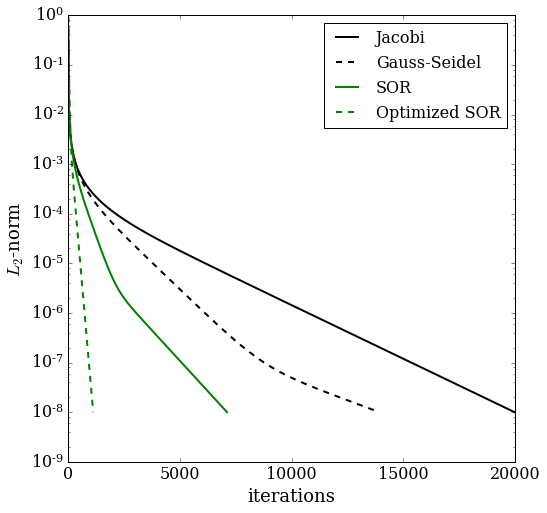

In [37]:
pyplot.figure(figsize=(8,8))
pyplot.xlabel(r'iterations', fontsize=18)
pyplot.ylabel(r'$L_2$-norm', fontsize=18)
pyplot.semilogy(numpy.trim_zeros(l2_diffJ,'b'),
                'k-', lw=2, label='Jacobi')
pyplot.semilogy(numpy.trim_zeros(l2_diffGS,'b'), 
                'k--', lw=2, label='Gauss-Seidel')
pyplot.semilogy(numpy.trim_zeros(l2_diffSOR,'b'), 
                'g-', lw=2, label='SOR')
pyplot.semilogy(numpy.trim_zeros(l2_diffSORopt,'b'), 
                'g--', lw=2, label='Optimized SOR')
pyplot.legend(fontsize=16);

The Jacobi method starts out with very fast convergence, but then it settles into a slower rate. Gauss-Seidel shows a faster rate in the first few thousand iterations, but it seems to be slowing down towards the end. SOR is a lot faster to converge, though, and optimized SOR just plunges down!

## References

1.  [Gonsalves, Richard J.  Computational Physics I. State University of New York, Buffalo: (2011): Section 3.1 ](http://www.physics.buffalo.edu/phy410-505/2011/index.html)

2. Moin, Parviz, "Fundamentals of Engineering Numerical Analysis," Cambridge University Press, 2nd edition (2010).

3. Young, David M. "A bound for the optimum relaxation factor for the successive overrelaxation method." Numerische Mathematik 16.5 (1971): 408-413.

In [31]:
from IPython.core.display import HTML
css_file = '../../styles/numericalmoocstyle.css'
HTML(open(css_file, "r").read())